Resources: 

1. [To translate or not to translate, best practices in non-English sentiment analysis](https://towardsdatascience.com/to-translate-or-not-to-translate-best-practices-in-non-english-sentiment-analysis-144a53613913)

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import seaborn as sns # visualization

import sentence_transformers  # NLP Embeddings
import umap  # Dimensionality reduction.
from sklearn.model_selection import train_test_split # train/test split

sns.set_theme() # set the plot style

In [3]:
# Read the data
data = pd.read_excel('data/train_sentiment_analysis.xlsx')
data.drop(columns=['Attraction'], inplace=True)
data['2022'] = [True for i in range(len(data))]
data.head()

,Title,Opinion,Polarity,2022
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1.0,True
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1.0,True
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1.0,True
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1.0,True
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1.0,True


In [4]:
print(len(data[data['Polarity'] == 1.0]))
print(len(data[data['Polarity'] == 5.0]))

547
20936


Text(0.5, 1.0, 'Polarity Distribution')

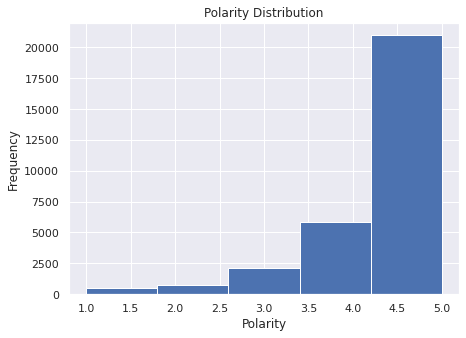

In [5]:
fig, ax = plt.subplots(figsize=(7,5))

hist = ax.hist(data['Polarity'], bins = 5)
ax.set_xlabel('Polarity')
ax.set_ylabel('Frequency')
ax.set_title('Polarity Distribution')

In [6]:
# Old data
data_2021 = pd.read_csv('data/sentiment_2021.csv')
data_2021.head(3)

,index,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,1,"""¡Momias, demasiado impresionante!""","""Las momias están en muy buen estado de conser...",Museo de las Momias,Male,53,México,22/10/2016,1
1,2,Comida cara,Tienen carteles con comida cortida de 40 y no ...,Mercado Hidalgo,N/I,-1,México,2018,1
2,3,"""No coman ahí""","""Creo que es muy insalubre, hay basura por tod...",Mercado Hidalgo,Female,61,México,15/01/2013,1


In [7]:
# Drop some columns
data_2021 = data_2021.drop(columns = ['Place', 'Gender', 'Age', 'Country', 'Date', 'index'])
# Rename label column to Polarity
data_2021.rename({'Label':'Polarity'}, axis = 'columns', inplace=True)
data_2021['2022'] = [False for i in range(len(data_2021))]
data_2021.head(3)

,Title,Opinion,Polarity,2022
0,"""¡Momias, demasiado impresionante!""","""Las momias están en muy buen estado de conser...",1,False
1,Comida cara,Tienen carteles con comida cortida de 40 y no ...,1,False
2,"""No coman ahí""","""Creo que es muy insalubre, hay basura por tod...",1,False


Text(0.5, 1.0, 'Polarity Distribution')

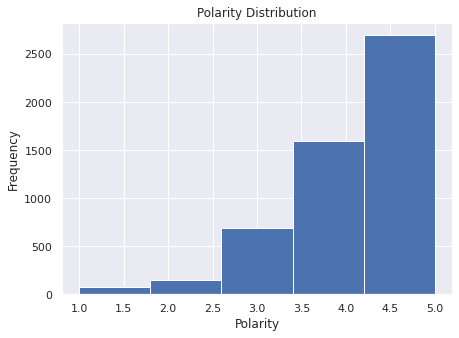

In [8]:
fig, ax = plt.subplots(figsize=(7,5))

ax.hist(data_2021['Polarity'], bins = 5)
ax.set_xlabel('Polarity')
ax.set_ylabel('Frequency')
ax.set_title('Polarity Distribution')

In [9]:
print(len(data_2021), len(data))

5197 30212


In [10]:
# Merge datasets
data = pd.concat([data, data_2021], ignore_index=True)
print(len(data))

35409


In [11]:
hist = ax.hist(data['Polarity'], bins = 5)

In [12]:
hist[0]

array([  627.,   875.,  2807.,  7474., 23626.])

In [13]:
maxi = hist[0].max()
for i in range(5):
    print(f'For label {i+1} search: {maxi - hist[0][i]}')

For label 1 search: 22999.0
For label 2 search: 22751.0
For label 3 search: 20819.0
For label 4 search: 16152.0
For label 5 search: 0.0


In [114]:
# Split in train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Option 1: Translate to english and use existing libraries.

In [101]:
from googletrans import Translator
from textblob import TextBlob

# Example: Spanish to English
def to_english(text):
    translator = Translator()
    return translator.translate(text, src='es', dest='en').text

def sentiment(text):
    if type(text) != str:
        return 0
    else:
        blob = TextBlob(text)
        num = blob.sentiment.polarity # From -1 to 1
        # Map to 1 to 5
        num = (num + 1) * 5/2 + 1

    # Return nearest integer
    return int(round(num))

example = to_english('Te odio idiota')
print(example, sentiment(example))

example = to_english('Eres lo mejor que me ha pasado en la vida')
print(example, sentiment(example))

I hate you, idiot 0
You are the best thing that ever happened to me 5


In [ ]:
translation = []

for i, text in enumerate(data_2021['Opinion']):
    translation.append(to_english(text))
    if i % 100 == 0:
        print(i)

In [59]:
data_2021['Translation'] = translation

In [99]:
# data_2021.to_csv('data/sentiment_2021_translated.csv')
data_2021 = pd.read_csv('data/sentiment_2021_translated.csv')

In [102]:
data_2021['Predicted'] = data_2021['Translation'].apply(sentiment)

In [103]:
from sklearn.metrics import confusion_matrix

# Get confusion matrix
confusion = pd.DataFrame(confusion_matrix(data_2021['Polarity'], data_2021['Predicted']))
confusion

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,1,5,33,33,7,1
2,0,5,65,69,6,0
3,2,4,125,440,108,7
4,1,3,160,914,474,44
5,2,8,210,1189,1133,148


In [104]:

# Get accuracy
accuracy = sum([confusion[i][i] for i in range(len(confusion))]) / len(data_2021)
print(accuracy)

0.21781797190686936


In [69]:
data_2021.head(10)

,Title,Opinion,Polarity,2022,Translation,Predicted
0,"""¡Momias, demasiado impresionante!""","""Las momias están en muy buen estado de conser...",1,False,"""The mummies are in a very good state of prese...",3
1,Comida cara,Tienen carteles con comida cortida de 40 y no ...,1,False,They have posters with fast food for 40 and th...,4
2,"""No coman ahí""","""Creo que es muy insalubre, hay basura por tod...",1,False,"""I think it is very unhealthy, there is garbag...",3
3,"""Momificado""","""Para mí gusto no vale la pena... tristemente ...",1,False,"""For my taste it's not worth it... sadly it's ...",3
4,"""Incómodo y cero romántico""","""Es un lugar poco interesante y que se conoce ...",1,False,"""It is an uninteresting place that is known in...",2
5,Muy descuidado,"Cierto, es un mercado, pero no por eso hay que...",1,False,"True, it is a market, but that is not why you ...",3
6,"""Horrible""","""Creí que era un museo dedicado a momias de ot...",1,False,"""I thought it was a museum dedicated to mummie...",3
7,"""Odioso""","""Largas filas para entrar, tickets caros, cobr...",1,False,"""Long lines to get in, expensive tickets, they...",2
8,"""No visitar""","""Es tardado entrar al museo, una vez dentro no...",1,False,"""It takes time to enter the museum, once insid...",3
9,"""Esperaba más""","""Es un lugar que la verdad, esperas algo mágic...",1,False,"""It is a place where the truth is, you expect ...",4


In [78]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    return float(analyzer.polarity_scores(text)['compound'])

In [79]:
sentiment('I hate you')

-0.5719

In [88]:
type('hola') == str

True

In [89]:
sent = []

for text in data_2021['Translation']:
    if type(text) != str:
        sent.append(0)
    else:
        n = sentiment(text)
        n = (n + 1) * 5/2
        sent.append(int(round(n)))

data_2021['Predicted'] = sent

In [95]:
from sklearn.metrics import confusion_matrix

# Get confusion matrix
confusion = pd.DataFrame(confusion_matrix(data_2021['Polarity'], data_2021['Predicted']))
confusion

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,11,23,11,13,13,9
2,17,23,29,21,34,21
3,23,52,98,118,244,151
4,10,46,146,141,626,627
5,9,26,165,208,962,1320


In [96]:
# Get accuracy
accuracy = sum([confusion[i][i] for i in range(len(confusion))]) / len(data_2021)
print(accuracy)

0.40715797575524343


In [124]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [135]:
print(classifier('I love you'), classifier('I hate you'), classifier('I am sick'))

[{'label': 'POSITIVE', 'score': 0.9998656511306763}] [{'label': 'NEGATIVE', 'score': 0.9991129040718079}] [{'label': 'NEGATIVE', 'score': 0.9996882677078247}]


# BERT and classifiers (automatic)

https://github.com/dccuchile/beto 

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d

In [136]:
data.head(3)

,Title,Opinion,Polarity,2022
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1.0,True
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1.0,True
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1.0,True


In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.25)
print(len(train), len(test))

26556 8853


In [14]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


2022-03-18 15:58:02.376302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-18 15:58:02.376956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 15:58:02.377416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-18 15:58:02.377991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-18 15:58:02.378438: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

KeyboardInterrupt: 

In [ ]:
def get_embeddings(sentences):
    '''return BERT-like embeddings of input text
    Args:
    - sentences: list of strings
    Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
    '''
    preprocessed_text = preprocessor(sentences)
    return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Questa collezione di Haiku è una porta aperta sulla cultura giapponese."]
)